In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
import os,subprocess

In [2]:
caco3_molar_mass = 100.0869 # g/mol
carbon_molar_mass = 12.011 # g/mol
cobalt_n_to_c = 106./16.
seconds_per_day = 86400.

# Read in Data

In [3]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-Control-062321','gfdl.ncrc4-intel16-prod'
#case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-013022','gfdl.ncrc4-intel19-prod'

In [4]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-013022":
    fig_casename='ms_gzCOBALT'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-Control-062321 gzCOBALT-Control-062321


In [5]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [6]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321


In [7]:
# read in files
diagTypes = ['ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension
#print(files)

In [8]:
if not files:
    pp_path=os.path.join(path_root, case, machine_target, 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
    print(files)


In [9]:
# FILE OVERRIDE
years=['1988-1992','1993-1997','1998-2002','2003-2007']
files = ['/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_tracers_int/av/annual_5yr/ocean_cobalt_tracers_int.' + yy + '.ann.nc' for yy in years]
files

['/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_tracers_int/av/annual_5yr/ocean_cobalt_tracers_int.1988-1992.ann.nc',
 '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_tracers_int/av/annual_5yr/ocean_cobalt_tracers_int.1993-1997.ann.nc',
 '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_tracers_int/av/annual_5yr/ocean_cobalt_tracers_int.1998-2002.ann.nc',
 '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_tracers_int/av/annual_5yr/ocean_cobalt_tracers_int.2003-2007.ann.nc']

In [10]:
#grid_file=os.path.join(path_root, case, machine_target, 'pp')+'/ocean_annual/ocean_annual.static.nc'
grid_file='/work/jyl/tmp/ocean_static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [11]:
ds = ds.mean(dim='time')

# Compute Global Carbon Biomass

In [12]:
ds.nsmp_100 # units of mol m-2

<xarray.DataArray 'nsmp_100' (yh: 576, xh: 720)>
dask.array<mean_agg-aggregate, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89

In [13]:
cobalt={}
cobalt['globalSum_gC']={}
cobalt['globalSum_gC']['smp'] = (ds.nsmp_100 * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass # g C
cobalt['globalSum_gC']['lgp'] = ((ds.nlgp_100+ds.ndi_100) * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass # g C
#cobalt['globalSum_gC']['lgp'] = ((ds.nlgp_100) * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass # g C
cobalt['globalSum_gC']['smz'] = (ds.nsmz_100 * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass  # g C
cobalt['globalSum_gC']['mdz'] = ((ds.nmdz_100) * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass  # g C
cobalt['globalSum_gC']['lgz'] = (ds.nlgz_100 * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass  # g C
#cobalt['globalSum_gC']['smt'] = (ds.nsmt_100 * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass  # g C
#cobalt['globalSum_gC']['lgt'] = (ds.nlgt_100 * grid.areacello).sum(dim=['xh','yh']).values * cobalt_n_to_c * carbon_molar_mass  # g C

cobalt

{'globalSum_gC': {'smp': 266779962080264.2,
  'lgp': 178895228756754.4,
  'smz': 247735921422303.22,
  'mdz': 181762520160829.44,
  'lgz': 128733586742525.94}}

In [14]:
biomass=pd.DataFrame.from_dict(cobalt)
biomass=biomass.reset_index()
biomass.columns.values[0]='name'
biomass

,name,globalSum_gC
0,lgp,1.788952e+14
1,lgz,1.287336e+14
2,mdz,1.817625e+14
3,smp,2.667800e+14
4,smz,2.477359e+14


# Separate the model data into log-equally sized bins.

In [15]:
sizes=np.linspace(np.log10(.5),np.log10(300.*1000.),num=1000,endpoint=False) # all size units are in micron
#10**(sizes)

In [16]:
dd=np.diff(sizes)[0]
sizes_min=10**(sizes-dd/2)
sizes_max=10**(sizes+dd/2)
size_range=[str(np.round(10**s,3))+': '+'['+str(np.round(x,3))+','+str(np.round(y,3))+')' for s,x,y in zip(sizes,sizes_min,sizes_max)]

In [17]:
sizedf=pd.DataFrame([10**sizes]).transpose()
sizedf.columns=['sizes']
sizedf['phyto']= None
sizedf['zoo']= None
sizedf['tun']= None
sizedf.loc[sizedf.sizes < 10,'phyto']='smp'

sizedf.loc[(sizedf.sizes > 10) & (sizedf.sizes < 100),'phyto']='lgp'
sizedf.loc[(sizedf.sizes > 20) & (sizedf.sizes < 200),'zoo']='smz'
sizedf.loc[(sizedf.sizes > 200) & (sizedf.sizes < 20000),'zoo']='mdz'
sizedf.loc[(sizedf.sizes > 2000) & (sizedf.sizes < 20000),'zoo']='lgz'
#sizedf.loc[(sizedf.sizes > 300) & (sizedf.sizes < 3000),'tun']='smt'
#sizedf.loc[(sizedf.sizes > 3000) & (sizedf.sizes < 300000),'tun']='lgt'

In [18]:
overlap=len(sizedf.loc[(sizedf.phyto=="lgp") & (sizedf.zoo=="smz")])
print("Overlap between large phytoplankton and small zooplankton is "+str(overlap)+" bins")

lenlgp=len(sizedf.loc[(sizedf.phyto=="lgp")])
print(str(overlap)+" bins out of "+str(lenlgp)+ " in Large Phytoplankton will need to be merged")

lensmz=len(sizedf.loc[(sizedf.zoo=="smz")])
print(str(overlap)+" bins out of "+str(lensmz)+ " in Small Zooplankton will need to be merged")

Overlap between large phytoplankton and small zooplankton is 121 bins
121 bins out of 173 in Large Phytoplankton will need to be merged
121 bins out of 173 in Small Zooplankton will need to be merged


In [19]:
sdfm = pd.melt(sizedf, id_vars='sizes',var_name='type',value_name='name')
sdfm = sdfm.dropna().reset_index(drop=True)
sdfm

,sizes,type,name
0,0.500000,phyto,smp
1,0.506697,phyto,smp
2,0.513483,phyto,smp
3,0.520361,phyto,smp
4,0.527330,phyto,smp
...,...,...,...
913,18848.022634,zoo,lgz
914,19100.465248,zoo,lgz
915,19356.288973,zoo,lgz
916,19615.539096,zoo,lgz


In [20]:
import math

sdfm['biovolume_um3']=(4/3)*math.pi*(sdfm.sizes/2)**3

sdfm['mg_carbon']=0

# non-diatoms, Menden-Deuer and Lessard 2000
sdfm.loc[sdfm.name=='smp','mg_carbon']=10**(-0.665) * sdfm.loc[sdfm.name=='smp','biovolume_um3']**0.939 * 1e-9
sdfm.loc[sdfm.name=='smz','mg_carbon']=10**(-0.665) * sdfm.loc[sdfm.name=='smz','biovolume_um3']**0.939 * 1e-9

# diatoms, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='lgp') & (sdfm.biovolume_um3 <= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='lgp') & (sdfm.biovolume_um3 <= 3000),'mg_carbon']=10**(-0.541 + 0.811 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='lgp') & (sdfm.biovolume_um3 > 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='lgp') & (sdfm.biovolume_um3 > 3000),'mg_carbon']=10**(-0.933 + 0.881 * np.log10(tmp)) * 1e-9

# mesozooplankton, Pitt et al. 2013
sdfm.loc[sdfm.name=='mdz','mg_carbon']= 0.06281 * (sdfm.loc[sdfm.name=='mdz','sizes']/1e3)**3
sdfm.loc[sdfm.name=='lgz','mg_carbon']= 0.06281 * (sdfm.loc[sdfm.name=='lgz','sizes']/1e3)**3

# appendicularians, Lombard et al. 2009
# body carbon (ug C) = 1.06e-7 * body size (um) ** 2.6
# body carbon (mg C) = 1.06e-7 * body size (um) ** 2.6 / 1000
sdfm.loc[sdfm.name=='smt','mg_carbon']= 1.06e-7 * (sdfm.loc[sdfm.name=='smt','sizes'])**2.6 * 1e-3

# salps - proxy for large tunicates. Madin and Deibel 1998 compiled by Luo et al. 2020
# body carbon (mg C) = 10^(-3.669) * body size (mm) ** 2.364
# body carbon (mg C) = 10^(-10.762) * (body size (um)) ** 2.364
sdfm.loc[sdfm.name=='lgt','mg_carbon']= 10**(-10.762) * (sdfm.loc[sdfm.name=='lgt','sizes'])**2.364

sdfm

,sizes,type,name,biovolume_um3,mg_carbon
0,0.500000,phyto,smp,6.544985e-02,1.671623e-11
1,0.506697,phyto,smp,6.811505e-02,1.735463e-11
2,0.513483,phyto,smp,7.088879e-02,1.801741e-11
3,0.520361,phyto,smp,7.377547e-02,1.870550e-11
4,0.527330,phyto,smp,7.677971e-02,1.941987e-11
...,...,...,...,...,...
913,18848.022634,zoo,lgz,3.505872e+12,4.205583e+02
914,19100.465248,zoo,lgz,3.648635e+12,4.376840e+02
915,19356.288973,zoo,lgz,3.797213e+12,4.555070e+02
916,19615.539096,zoo,lgz,3.951840e+12,4.740559e+02


# Pull together & Merge Overlapping Bins

In [21]:
sdfm['globalSum_gC_split']=0
for s in ['smp','lgp','smz','mdz','lgz','smt','lgt']:
    n=len(sdfm.loc[sdfm.name==s].index)
    #print(s, n)
    sdfm.loc[sdfm.name==s,'globalSum_gC_split'] = np.tile(biomass.loc[biomass.name==s,'globalSum_gC']/n,n)

In [22]:
sdfm = sdfm.sort_values(by='mg_carbon', ascending=True)

In [23]:
small_increment = (sdfm['mg_carbon'][1]-sdfm['mg_carbon'][0])/2

In [24]:
# create log-spaced bins for mg_carbon
bins = np.logspace(np.log10(sdfm['mg_carbon'].min()-small_increment), np.log10(sdfm['mg_carbon'].max()+small_increment), 51)

# use pandas.cut to bin the data into log-spaced bins
sdfm['mg_carbon_bin'] = pd.cut(sdfm['mg_carbon'], bins=bins, include_lowest=True)

sdfm

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_gC_split,mg_carbon_bin
0,0.500000,phyto,smp,6.544985e-02,1.671623e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]"
1,0.506697,phyto,smp,6.811505e-02,1.735463e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]"
2,0.513483,phyto,smp,7.088879e-02,1.801741e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]"
3,0.520361,phyto,smp,7.377547e-02,1.870550e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]"
4,0.527330,phyto,smp,7.677971e-02,1.941987e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]"
...,...,...,...,...,...,...,...
913,18848.022634,zoo,lgz,3.505872e+12,4.205583e+02,7.441248e+11,"(265.214, 493.36]"
914,19100.465248,zoo,lgz,3.648635e+12,4.376840e+02,7.441248e+11,"(265.214, 493.36]"
915,19356.288973,zoo,lgz,3.797213e+12,4.555070e+02,7.441248e+11,"(265.214, 493.36]"
916,19615.539096,zoo,lgz,3.951840e+12,4.740559e+02,7.441248e+11,"(265.214, 493.36]"


In [25]:
logdiff = np.diff(np.log10(bins))[0]
bin_centers = 10**(np.log10(bins) + logdiff/2)

In [26]:
bin_centers = bin_centers[0:-1] #select all but the last value in bincenters

In [27]:
# get all the unique bin values and sort them
unique_bins = np.sort(sdfm['mg_carbon_bin'].unique())
bin_info = pd.DataFrame({
    'mg_carbon_bin': unique_bins,
    'bin_centers': bin_centers})

# join the bin_info dataframe with the sdfm dataframe by the mg_carbon_bin column
sdfm = sdfm.merge(bin_info, on='mg_carbon_bin')
sdfm

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_gC_split,mg_carbon_bin,bin_centers
0,0.500000,phyto,smp,6.544985e-02,1.671623e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]",2.236398e-11
1,0.506697,phyto,smp,6.811505e-02,1.735463e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]",2.236398e-11
2,0.513483,phyto,smp,7.088879e-02,1.801741e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]",2.236398e-11
3,0.520361,phyto,smp,7.377547e-02,1.870550e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]",2.236398e-11
4,0.527330,phyto,smp,7.677971e-02,1.941987e-11,1.180442e+12,"(-0.0009999999836, 3.05e-11]",2.236398e-11
...,...,...,...,...,...,...,...,...
913,18848.022634,zoo,lgz,3.505872e+12,4.205583e+02,7.441248e+11,"(265.214, 493.36]",3.617262e+02
914,19100.465248,zoo,lgz,3.648635e+12,4.376840e+02,7.441248e+11,"(265.214, 493.36]",3.617262e+02
915,19356.288973,zoo,lgz,3.797213e+12,4.555070e+02,7.441248e+11,"(265.214, 493.36]",3.617262e+02
916,19615.539096,zoo,lgz,3.951840e+12,4.740559e+02,7.441248e+11,"(265.214, 493.36]",3.617262e+02


In [28]:
df_grouped = sdfm.groupby(['mg_carbon_bin','bin_centers','name']).agg(biovolume_um3=('biovolume_um3','mean'),
                                                                      sizes=('sizes','mean'),
                                                                      globalSum_gC=('globalSum_gC_split','sum'))
df_grouped = df_grouped.dropna().reset_index()
df_grouped

,mg_carbon_bin,bin_centers,name,biovolume_um3,sizes,globalSum_gC
0,"(-0.0009999999836, 3.05e-11]",2.236398e-11,smp,9.180264e-02,0.557336,2.006752e+13
1,"(3.05e-11, 5.67e-11]",4.160227e-11,smp,1.769820e-01,0.693987,1.888708e+13
2,"(5.67e-11, 1.06e-10]",7.739003e-11,smp,3.426827e-01,0.864562,2.006752e+13
3,"(1.06e-10, 1.96e-10]",1.439637e-10,smp,6.606419e-01,1.076540,1.888708e+13
4,"(1.96e-10, 3.65e-10]",2.678064e-10,smp,1.279173e+00,1.341144,2.006752e+13
5,"(3.65e-10, 6.79e-10]",4.981830e-10,smp,2.466057e+00,1.669972,1.888708e+13
6,"(6.79e-10, 1.26e-09]",9.267379e-10,smp,4.774920e+00,2.080436,2.006752e+13
7,"(1.26e-09, 2.35e-09]",1.723951e-09,smp,9.205345e+00,2.590527,1.888708e+13
8,"(2.35e-09, 4.37e-09]",3.206955e-09,smp,1.782391e+01,3.227255,2.006752e+13
9,"(4.37e-09, 8.14e-09]",5.965692e-09,smp,3.513086e+01,4.046335,2.006752e+13


# Calculate Spectral Slopes Globally

In [29]:
yh = ds.yh
xh = ds.xh
mgC = np.log10(bin_info.bin_centers)
data = np.zeros((len(mgC), len(yh), len(xh)))

#time = ds.time
#data = np.zeros((len(time), len(mmolC), len(z_t_150m), len(nlat), len(nlon)))
#biomass_all = xr.DataArray(data, coords={'time':time, 'mass_mmolC':mmolC, 'z_t_150m':z_t_150m, 'nlat':nlat, 'nlon':nlon},
#            dims = ['time', 'mass_mmolC', 'z_t_150m', 'nlat', 'nlon'])

biomass_all = xr.DataArray(data, coords={'mass_mgC':mgC, 'yh':yh, 'xh':xh},
            dims = ['mass_mgC', 'yh', 'xh'])
biomass_all.shape

(50, 576, 720)

In [30]:
for v in ['smp','lgp','smz','mdz','lgz']:
    cobaltvar = 'n' + v + '_100'
    x = ds[cobaltvar]
    if v == 'lgp':
        x = x + ds['ndi_100']
    x = x.values * cobalt_n_to_c * carbon_molar_mass # to g C
    
    # split up 
    n_split = len(df_grouped.loc[df_grouped.name==v].index)
    mg_carbon = df_grouped.loc[df_grouped.name==v,'bin_centers'].values
    x_split = x / n_split
    
    x_rep = np.repeat(x_split[np.newaxis,...], n_split, axis=0)
    x_rep = x_rep / (mg_carbon[:,None,None] * 1e-3) # normalized biomass = integrated biomass / size-class
    x_rep = np.log10(x_rep)
    # units are : gC / m^2 / gC ind-1
    
    # extract the indices corresponding to the bins where the plankton groups fall
    pft_bins=pd.unique(df_grouped.where(df_grouped.name==v).dropna().bin_centers)
    subset = bin_info[bin_info['bin_centers'].isin(pft_bins)]
    
    index_dims = subset.index.values
    
    # check lengths are the same
    if (n_split != len(index_dims)):
        print("Error: Dimension lengths are not the same")
        break
    
    biomass_vals = biomass_all[index_dims,:,:].values
    biomass_vals = biomass_vals + x_rep
    
    # put into matrix
    biomass_all.values[index_dims,:,:] = biomass_vals

/vftmp/Jessica.Luo/pid5147/ipykernel_6518/2595368748.py:15: RuntimeWarning: divide by zero encountered in log10
  x_rep = np.log10(x_rep)
/vftmp/Jessica.Luo/pid5147/ipykernel_6518/2595368748.py:15: RuntimeWarning: divide by zero encountered in log10
  x_rep = np.log10(x_rep)


In [31]:
biomass_all.mass_mgC.values

array([-10.65045097, -10.38088299, -10.11131501,  -9.84174703,
        -9.57217905,  -9.30261107,  -9.03304309,  -8.76347511,
        -8.49390713,  -8.22433915,  -7.95477118,  -7.6852032 ,
        -7.41563522,  -7.14606724,  -6.87649926,  -6.60693128,
        -6.3373633 ,  -6.06779532,  -5.79822734,  -5.52865937,
        -5.25909139,  -4.98952341,  -4.71995543,  -4.45038745,
        -4.18081947,  -3.91125149,  -3.64168351,  -3.37211553,
        -3.10254755,  -2.83297958,  -2.5634116 ,  -2.29384362,
        -2.02427564,  -1.75470766,  -1.48513968,  -1.2155717 ,
        -0.94600372,  -0.67643574,  -0.40686777,  -0.13729979,
         0.13226819,   0.40183617,   0.67140415,   0.94097213,
         1.21054011,   1.48010809,   1.74967607,   2.01924404,
         2.28881202,   2.55838   ])

In [32]:
def calculate_size_spectra_slopes(data):
    cov_x = (data.mass_mgC.values - data.mass_mgC.mean().values)[:,None,None]
    cov_y = (data.values - data.mean(dim='mass_mgC').values[None,:,:])
    cov_xy = cov_x * cov_y
    covariance = np.nansum(cov_xy,axis=0)

    #variance = (data.mass_mgC.values.var() * (len(data.mass_mgC.values) - 1.))
    variance = np.nansum(cov_x**2, axis=0)
    
    betas = covariance / variance
    betas[betas == 0] = np.nan
    
    return betas

In [33]:
betas = calculate_size_spectra_slopes(biomass_all)
betas.shape

/vftmp/Jessica.Luo/pid5147/ipykernel_6518/3531712945.py:3: RuntimeWarning: invalid value encountered in subtract
  cov_y = (data.values - data.mean(dim='mass_mgC').values[None,:,:])
/net/Jessica.Luo/miniconda3/envs/nice_plotting/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(576, 720)

In [34]:
np.nanmean(betas)

-1.187415648141849

# Plot

Text(0.5, 1.0, 'ESM4 Historical Spectra Slope')

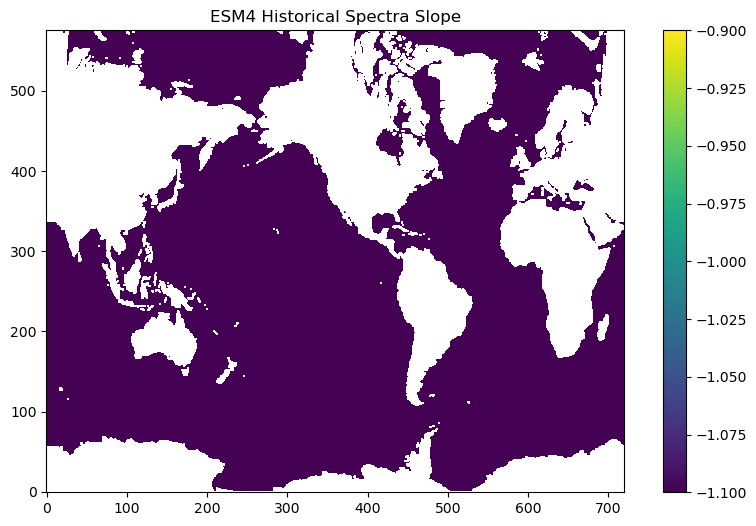

In [35]:
fig=plt.figure(figsize=(10,6))
plt.imshow(betas, origin='lower',vmin=-1.1,vmax=-0.9)
plt.colorbar()
plt.title('ESM4 Historical Spectra Slope')

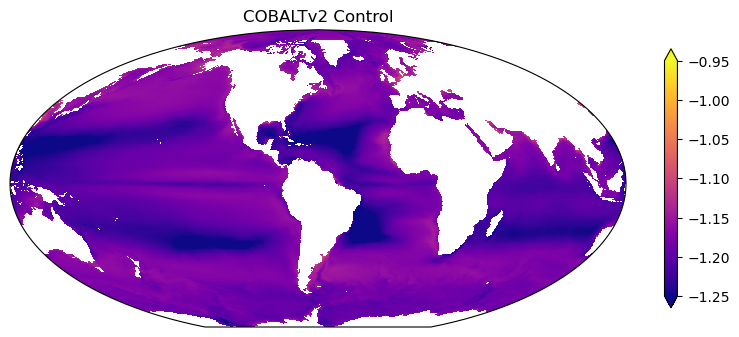

In [43]:
plt.figure(figsize=(8,4))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

val = betas

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, val, transform=ccrs.PlateCarree(), vmax=-0.95, vmin=-1.25, cmap='plasma')
plt.colorbar(cs, extend='both', shrink=0.7)
plt.title('COBALTv2 Control')

plt.tight_layout()
plt.savefig('plots/'+short_casename+'_size_spectra_slopes.png', dpi=150, bbox_inches='tight')

In [37]:
nbss_slopes = xr.DataArray(betas, coords={'yh':ds.yh, 'xh':ds.xh}, dims=['yh','xh']).to_dataset(name='NBSS_slopes_Ctrl')
nbss_slopes

<xarray.Dataset>
Dimensions:           (yh: 576, xh: 720)
Coordinates:
  * yh                (yh) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * xh                (xh) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
Data variables:
    NBSS_slopes_Ctrl  (yh, xh) float64 nan nan nan nan nan ... nan nan nan nan

In [38]:
nbss_slopes.to_netcdf('data/NBSS_slopes_Ctrl-COBALTv2.nc',mode='w')